### League of Legends: Model Training
Standard Methodology:

1. Exploratory plots to get a sense of data (e.g. relationships, distribution etc.)
2. **Perform transformations (standardization, log-transform, PCA etc.)**
3. **Experiment with algorithms that make sense, feature selection and compare cross-validated performance.Algos to thinks about: Tree-Based, Basis Expansion, Logistic Regression, Discriminant  Analysis, Boosting, Neural Nets...**

4. **Run on test set**

In [269]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import math
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
import scipy.stats as stats
import sklearn.metrics as metrics
from sklearn.pipeline import FeatureUnion


#BaseEstimator will inherit get_parms and set_parms methods. 
#TransformerMixin will inherit fit_transform, which calls fit and transform. We can customize our fit and transform
#These are used for consistency with existing sklearn classes
from sklearn.base import BaseEstimator, TransformerMixin

In [6]:
def read_pickle(path):
    
    input_file = open(path,'rb')
    variable = pickle.load(input_file)
    input_file.close()
    return(variable)

In [367]:
x_train = '../data/x_train.pickle'
x_test = '../data/x_test.pickle'
y_train = '../data/y_train.pickle'
y_test = '../data/y_test.pickle'

x_train = read_pickle(x_train) 
x_test = read_pickle(x_test) 
y_train = read_pickle(y_train) 
y_test = read_pickle(y_test) 

In [368]:
x_train.columns

Index(['gameid', 'delta_assists', 'delta_damagetochampions', 'delta_deaths',
       'delta_kills', 'delta_monsterkills', 'delta_total_cs',
       'delta_totalgold', 'delta_wardskilled', 'delta_wardsplaced',
       'delta_armor', 'delta_armorperlevel', 'delta_attackdamage',
       'delta_attackdamageperlevel', 'delta_attackrange', 'delta_attackspeed',
       'delta_attackspeedperlevel', 'delta_crit', 'delta_critperlevel',
       'delta_gap_closer_value', 'delta_hard_cc_value', 'delta_hp',
       'delta_hpperlevel', 'delta_hpregen', 'delta_hpregenperlevel',
       'delta_movespeed', 'delta_mp', 'delta_mpperlevel', 'delta_mpregen',
       'delta_mpregenperlevel', 'delta_protection_value',
       'delta_soft_cc_value', 'delta_spellblock', 'delta_spellblockperlevel',
       'delta_spells_average_range_value', 'delta_Assassin', 'delta_Fighter',
       'delta_Mage', 'delta_Marksman', 'delta_Support', 'delta_Tank',
       'gamelength'],
      dtype='object')

### Transformations ###

Let's begin with applying the transformations we deemed suitable during EDA. 
1. Standardize the data, 
2. Remove crit and crit per level variables 
3. Log cs feature 
4. Create per level * gamelength variable
5. Perform PCA with 30 components

In [135]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, select_features):
        self.select_features = select_features
    
    def fit(self, x_df):
        return self
    
    def transform(self, x_df):
        
        x_df = x_df[select_features]
        return(x_df)
    
class ContinuousFeatureEngineering(BaseEstimator, TransformerMixin):
    
    #Initiate class
    def __init__(self): 
        return None
        
    #We don't need to fit anything, so leave this as is
    def fit(self, x_df):
        return self
    
    #Perform our feature transformations
    def transform(self, x_df):
        
        #Log cs field
        add_constant = abs(min(x_df['delta_total_cs']))
        x_df['log_delta_total_cs'] = x_df['delta_total_cs'].apply(lambda x : math.log(x + add_constant + 0.01))
        x_df = x_df.drop('delta_total_cs', axis = 1)
        
        #Create per_level * gamelength variables
        feature_columns = list(x_df.columns)
        per_level = [feature for feature in feature_columns if "perlevel" in feature]
        
        for i in per_level:
            field_name = i + str('_average_gamelength')
            x_df[field_name] = x_df[i] * x_df['average_gamelength']
        
        #Standardize data
        standard_scaler = preprocessing.StandardScaler()
        x_df = standard_scaler.fit_transform(x_df)
        
        return(x_df)
    

In [137]:
num_attributes = ['delta_assists', 'delta_damagetochampions', 'delta_deaths',
       'delta_kills', 'delta_monsterkills', 'delta_total_cs',
       'delta_totalgold', 'delta_wardskilled', 'delta_wardsplaced',
       'delta_armor', 'delta_armorperlevel', 'delta_attackdamage',
       'delta_attackdamageperlevel', 'delta_attackrange', 'delta_attackspeed',
       'delta_attackspeedperlevel','delta_gap_closer_value', 'delta_hard_cc_value', 'delta_hp',
       'delta_hpperlevel', 'delta_hpregen', 'delta_hpregenperlevel',
       'delta_movespeed', 'delta_mp', 'delta_mpperlevel', 'delta_mpregen',
       'delta_mpregenperlevel', 'delta_protection_value',
       'delta_soft_cc_value', 'delta_spellblock', 'delta_spellblockperlevel',
       'delta_spells_average_range_value', 'delta_Assassin', 'delta_Fighter',
       'delta_Mage', 'delta_Marksman', 'delta_Support', 'delta_Tank',
       'gamelength']


numerical_pipeline = Pipeline([
    
    ('FeatureSelector', FeatureSelector(num_attributes)),
    ('FeatureEngineering', FeatureEngineering()),
    ('PCA', PCA(n_components = 30))
])

x_train_prepared  = numerical_pipeline.fit_transform(x_train)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Model Training ###

List of initial candiate models:

1. Logistic Regression
2. CART models
3. Bagging (Random Forest)
4. Boosting
5. Others...

In [255]:
#Plot ROC Curve
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
#Plot basic diagnostics
def classification_diagnostics(model, x, y, standardize = True, classifier = True):
    
    fig, axs = plt.subplots(nrows = 1, ncols=2, figsize = (15,4))
    
    if classifier == True:
        
        y_hat = model.predict_proba(x)[:, 1]
        residuals = y - y_hat
        std_error = math.sqrt(np.var(residuals))
        std_residuals = residuals/std_error
        
    else:
        
        y_hat = model.predict(x)
        residuals = y_hat - y
        std_error = math.sqrt(np.var(residuals))
        std_residuals = residuals/std_error
        
    #Residual vs Fitted Plot
    sns.regplot(y_hat, 
                std_residuals, 
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 1},
                ax = axs[0])
    
    #Histogram of residuals
    sns.distplot(std_residuals, 
                hist=True,
                ax = axs[1])
    
    #Labels
    axs[0].set(xlabel="Fitted Values", 
                ylabel="Pearson's Standardized Residuals", 
                title = 'Residual vs Fitted')
    
    axs[1].set(xlabel="Fitted Values", 
                ylabel="Frequency", 
                title = "Residuals Histogram")
    
    #plt.title("Diagnostic Plots")

    
#Deviance used in R but we can just use std residuals
#def deviance(X, y, model):
#    return 2*metrics.log_loss(y, model.predict_proba(X)[:,1].reshape(-1), normalize=False)

Begin with zero tuning, just to grasp a baseline for each algorithm. Then we'll start tuning and compare the best model of each algorithm

CV Scores:  [0.41803981 0.38161639 0.44280744 0.39605902 0.50487816 0.42008403
 0.45374261 0.43159531 0.47720307 0.4975186 ]
Mean CV Scores:  0.44235444283898906


//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


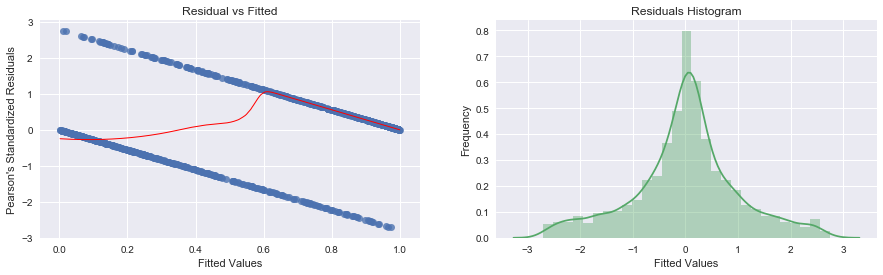

In [258]:
#Begin with baseline logistic regression
log_reg_model = LogisticRegression()
log_reg_model.fit(x_train_prepared, y_train)

scores = cross_val_score(log_reg_model, x_train_prepared, y_train,
                        scoring = "neg_mean_squared_error", cv = 10)
rmse_scores = np.sqrt(-scores)
print('CV Scores: ', rmse_scores)
print('Mean CV Scores: ', np.mean(rmse_scores))
classification_diagnostics(log_reg_model, x_train_prepared, y_train, standardize = True, classifier = True)

CV Scores:  [0.47254732 0.53968707 0.48507125 0.48507125 0.48507125 0.51449576
 0.45374261 0.58577919 0.51703649 0.53584393]
Mean CV Scores:  0.5074346108298406


//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


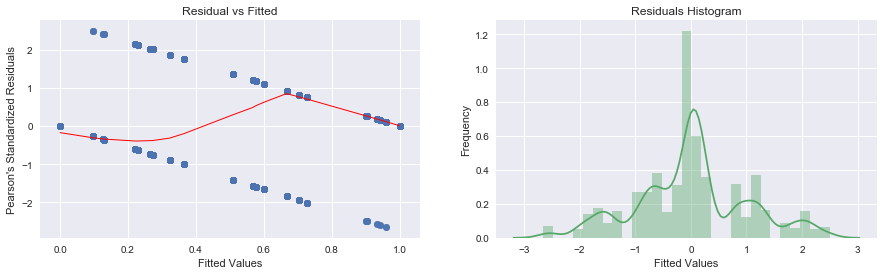

In [265]:
#CART Model
cart_model = DecisionTreeClassifier(min_samples_leaf = 30) #blanket default, to avoid 1 observation per leaf
cart_model.fit(x_train_prepared, y_train)

scores = cross_val_score(cart_model, x_train_prepared, y_train,
                        scoring = "neg_mean_squared_error", cv = 10)
rmse_scores = np.sqrt(-scores)

print('CV Scores: ', rmse_scores)
print('Mean CV Scores: ', np.mean(rmse_scores))
classification_diagnostics(cart_model, x_train_prepared, y_train, standardize = True, classifier = True)

CV Scores:  [0.50242132 0.48271079 0.53321077 0.45374261 0.58577919 0.52393683
 0.52393683 0.51449576 0.53584393 0.53584393]
Mean CV Scores:  0.5191921947659732


//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


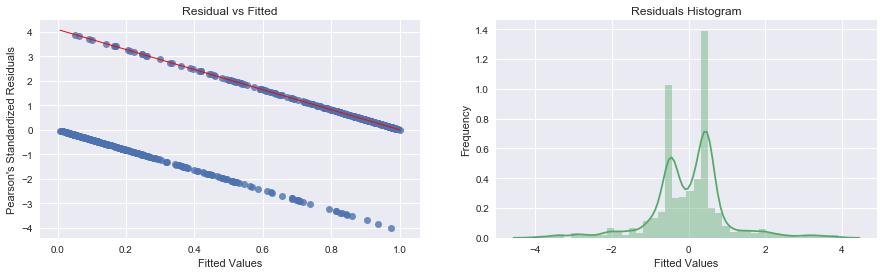

In [271]:
#SVM
svm_model = SVC(probability = True)
svm_model.fit(x_train_prepared, y_train)

scores = cross_val_score(rand_forest_model, x_train_prepared, y_train,
                        scoring = "neg_mean_squared_error", cv = 10)
rmse_scores = np.sqrt(-scores)
print('CV Scores: ', rmse_scores)
print('Mean CV Scores: ', np.mean(rmse_scores))
classification_diagnostics(svm_model, x_train_prepared, y_train, standardize = True, classifier = True)

CV Scores:  [0.44065265 0.4515346  0.53321077 0.48507125 0.58577919 0.52393683
 0.54232614 0.57735027 0.5073714  0.56287804]
Mean CV Scores:  0.5210111142315391


//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


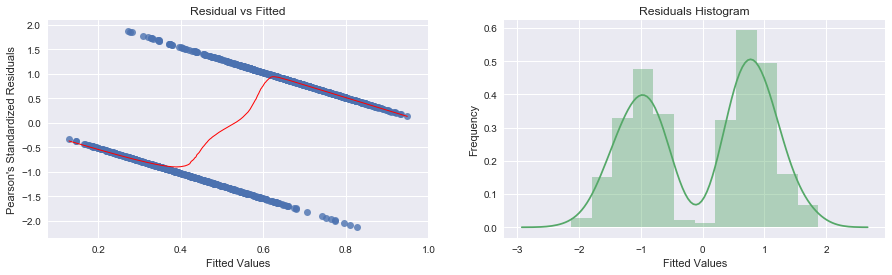

In [267]:
#Random Forest Model
rand_forest_model = RandomForestClassifier(min_samples_leaf = 30)
rand_forest_model.fit(x_train_prepared, y_train)

scores = cross_val_score(rand_forest_model, x_train_prepared, y_train,
                        scoring = "neg_mean_squared_error", cv = 10)
rmse_scores = np.sqrt(-scores)
print('CV Scores: ', rmse_scores)
print('Mean CV Scores: ', np.mean(rmse_scores))
classification_diagnostics(rand_forest_model, x_train_prepared, y_train, standardize = True, classifier = True)

CV Scores:  [0.41803981 0.44065265 0.45374261 0.42008403 0.48507125 0.48507125
 0.49507377 0.49507377 0.52652419 0.54500431]
Mean CV Scores:  0.4764337637376917


//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


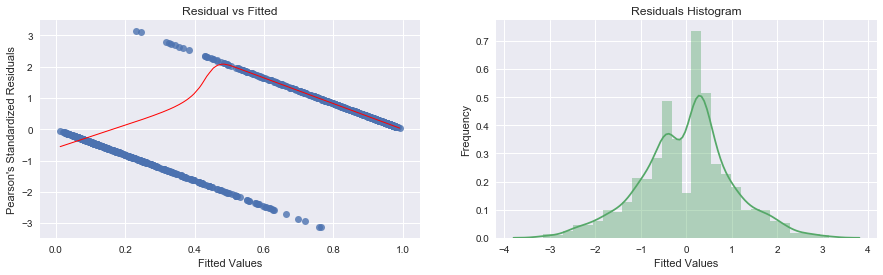

In [268]:
#Boosting Model
gboost_model = GradientBoostingClassifier()
gboost_model.fit(x_train_prepared, y_train)

scores = cross_val_score(gboost_model, x_train_prepared, y_train,
                        scoring = "neg_mean_squared_error", cv = 10)
rmse_scores = np.sqrt(-scores)
print('CV Scores: ', rmse_scores)
print('Mean CV Scores: ', np.mean(rmse_scores))
classification_diagnostics(gboost_model, x_train_prepared, y_train, standardize = True, classifier = True)

**Note**: For SVM, Random Forest and Gradient Boosting, we're seeing a bimodal distribution in the residuals. Perhaps we're missing a categorical variable that can help us cleanly separate the distribution and possible win-loss predictions.

In [343]:
#Checking random forest bimodal
rf_residuals = y_train - rand_forest_model.predict_proba(x_train_prepared)[:, 1]
std_error = math.sqrt(np.var(rf_residuals))
std_rf_residuals = rf_residuals/std_error
less_than_zero = list(std_rf_residuals.where(std_rf_residuals < 0).dropna().index)
greater_than_zero = list(std_rf_residuals.where(std_rf_residuals > 0).dropna().index)

greater_gameids = x_train.loc[greater_than_zero]['gameid']
less_gameids = x_train.loc[less_than_zero]['gameid']

In [325]:
#Check raw data to see if we spot anything
matches = pd.read_csv('../data/2020 spring match data OraclesElixir 2020-05-15.csv')
matches = matches[matches['side'] == 'Blue']
greater_matches = matches[matches['gameid'].isin(greater_gameids)]
lesser_matches = matches[matches['gameid'].isin(less_gameids)]

In [362]:
print(greater_matches[['elementaldrakes', 'game']].groupby('elementaldrakes').count())
print(lesser_matches[['elementaldrakes', 'game']].groupby('elementaldrakes').count())

                 game
elementaldrakes      
0.0                 5
1.0                18
2.0                61
3.0               117
4.0               204
                 game
elementaldrakes      
0.0                82
1.0               101
2.0                65
3.0                47
4.0                15


In [366]:
print(greater_matches[['opp_elementaldrakes', 'game']].groupby('opp_elementaldrakes').count())
print(lesser_matches[['opp_elementaldrakes', 'game']].groupby('opp_elementaldrakes').count())

                     game
opp_elementaldrakes      
0.0                   112
1.0                   110
2.0                   107
3.0                    54
4.0                    22
                     game
opp_elementaldrakes      
0.0                     5
1.0                    10
2.0                    34
3.0                    77
4.0                   184


In [360]:
print(greater_matches[['barons', 'game']].groupby('barons').count())
print(lesser_matches[['barons', 'game']].groupby('barons').count())

        game
barons      
0.0      100
1.0      361
2.0       97
3.0        4
        game
barons      
0.0      380
1.0       66
2.0       10
3.0        1


In [365]:
print(greater_matches[['firsttower', 'game']].groupby('firsttower').count())
print(lesser_matches[['firsttower', 'game']].groupby('firsttower').count())

            game
firsttower      
0.0          150
1.0          412
            game
firsttower      
0.0          281
1.0          176


It seems like we can really benefit from bringing in these features to reflect objective control. Might help us with capturing that bimodal split.

------------------

### New Features

Added binary variables for blue and red soul point (>= 3 dragons). Also adjusted gamelength to be average of average (the average between the 5 game running avearge of both teams). Let's see if our new features can help with separating the bimodal distribution.

In [369]:
x_train = '../data/x_train_v2.pickle'
x_test = '../data/x_test_v2.pickle'
y_train = '../data/y_train_v2.pickle'
y_test = '../data/y_test_v2.pickle'

x_train = read_pickle(x_train) 
x_test = read_pickle(x_test) 
y_train = read_pickle(y_train) 
y_test = read_pickle(y_test) 

In [371]:
num_attributes = ['delta_assists', 'delta_damagetochampions', 'delta_deaths',
       'delta_kills', 'delta_monsterkills', 'delta_total_cs',
       'delta_totalgold', 'delta_wardskilled', 'delta_wardsplaced',
       'delta_armor', 'delta_armorperlevel', 'delta_attackdamage',
       'delta_attackdamageperlevel', 'delta_attackrange', 'delta_attackspeed',
       'delta_attackspeedperlevel','delta_gap_closer_value', 'delta_hard_cc_value', 'delta_hp',
       'delta_hpperlevel', 'delta_hpregen', 'delta_hpregenperlevel',
       'delta_movespeed', 'delta_mp', 'delta_mpperlevel', 'delta_mpregen',
       'delta_mpregenperlevel', 'delta_protection_value',
       'delta_soft_cc_value', 'delta_spellblock', 'delta_spellblockperlevel',
       'delta_spells_average_range_value', 'delta_Assassin', 'delta_Fighter',
       'delta_Mage', 'delta_Marksman', 'delta_Support', 'delta_Tank',
       'average_gamelength']

categorical_attributes = ['soul_point', 'red_soul_point']

In [ ]:
numerical_pipeline = Pipeline([
    
    ('FeatureSelector', FeatureSelector(num_attributes)),
    ('FeatureEngineering', FeatureEngineering()),
    ('PCA', PCA(n_components = 30))
])

categorical_pipeline = Pipeline([
    
    ('FeatureSelector', FeatureSelector(num_attributes))
])

pipeline = F

#x_train_prepared  = numerical_pipeline.fit_transform(x_train)

### Model Training + Tuning:

Let's see if we can improve the performance of each algorithm by:

1. Feature Selection (parsimonious models tend to generalize better)
2. Hyperparameter Tuning (many algos performs feature selection through their hyperparameters)

There are two general approaches for feature selection-- discrete model selection and "continuous" shrinkage methods. The two approaches relate to bias-variance tradeoff. Discrete methods add and takeout features, and tend to recommend simplier models (lower bias) which generalize better, but introduces higher variance (poorer fit). Shrinkage methods, on the other hand, tend to recommend models with better fit since they can lower parameter weights instead of completely removing the variable.

In [149]:
#y_scores = cross_val_predict(log_reg_model, x_train_prepared, y_train, cv = 10, method = 'decision_function')
#fpr, tpr, thresholds = roc_curve(y_train, y_scores)
#plot_roc_curve(fpr, tpr)
#plt.show()